In [1]:
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import statsmodels.api as sm
%matplotlib inline

In [4]:
sheet1 = pd.read_csv('/Users/skylark/Desktop/deep nlp/datasets_897_1638_Sheet_1.csv')
sheet1.head()

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN


In [8]:
sheet2 = pd.read_csv('/Users/skylark/Desktop/deep nlp/datasets_897_1638_Sheet_2.csv', encoding='latin1')
sheet2.head()

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...


### Preprocessing

In [19]:
pat1 = re.compile(r'\w{2,}')

In [21]:
pat2 = re.compile(r'\D+')

In [34]:
sheet1_target = pd.DataFrame(sheet1_target)
sheet2_target = pd.DataFrame(sheet2_target)

In [35]:
sheet1_text = pd.DataFrame(sheet1.response_text)
sheet2_text = pd.DataFrame(sheet2.resume_text)

In [40]:
sheet1_text['text'] = sheet1_text.response_text.map(lambda x: ' '.join(pat1.findall(x.lower())))
sheet1_text['text'] = sheet1_text.text.map(lambda x: ''.join(pat2.findall(x.lower())))

In [44]:
sheet2_text['text'] = sheet2_text.resume_text.map(lambda x: ' '.join(pat1.findall(x.lower())))
sheet2_text['text'] = sheet2_text.text.map(lambda x: ''.join(pat2.findall(x.lower())))

In [50]:
sheet1_target['target'] = sheet1_target['class'].map(lambda x: 1 if x=='flagged' else 0)
sheet2_target['target'] = sheet2_target['class'].map(lambda x: 1 if x=='flagged' else 0)

In [53]:
text = pd.concat([sheet1_text.text, sheet2_text.text])

In [54]:
target = pd.concat([sheet1_target.target, sheet2_target.target])

In [61]:
text.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

#### stemming & lemmatization

In [73]:
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [74]:
stemmer = PorterStemmer()
lemmet = WordNetLemmatizer()
toknzr = TreebankWordTokenizer()

In [68]:
stop_words = stopwords.words('english')

In [84]:
def analyser(data):
    lemmed = [lemmet.lemmatize(word) for word in toknzr.tokenize(data) if word not in stop_words]
    stemmed = [stemmer.stem(word) for word in lemmed]
    return stemmed

### TFiDF

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [96]:
tfidf = TfidfVectorizer(max_features=300, analyzer=analyser, ngram_range=(1,3))
tfidf.fit(text)

TfidfVectorizer(analyzer=<function analyser at 0x13202fa70>, binary=False,
                decode_error='strict', dtype=<class 'numpy.float64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                max_features=300, min_df=1, ngram_range=(1, 3), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [97]:
features = tfidf.get_feature_names()

In [98]:
tfidf_vector = tfidf.transform(text)

In [99]:
text_df = pd.DataFrame(tfidf_vector.todense(), columns=features)

In [105]:
data = pd.concat([text_df, target], axis=1)

In [106]:
from sklearn.utils import resample
data = resample(data, replace=True, n_samples=500)

In [108]:
x = data.drop('target', axis=1)
y = data.target

### Model

In [116]:
from sklearn.metrics import classification_report, confusion_matrix

In [115]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

#### Bernoulli

In [113]:
bnb = BernoulliNB()
bnb.fit(train_x, train_y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [114]:
bnb.score(test_x, test_y)

0.66

In [117]:
print(classification_report(test_y, bnb.predict(test_x)))

              precision    recall  f1-score   support

           0       0.83      0.60      0.70        65
           1       0.51      0.77      0.61        35

    accuracy                           0.66       100
   macro avg       0.67      0.69      0.66       100
weighted avg       0.72      0.66      0.67       100



In [121]:
confusion_matrix(test_y, bnb.predict(test_x),[1,0])

array([[27,  8],
       [26, 39]])

#### Gaussian

In [122]:
gnb = GaussianNB()
gnb.fit(train_x, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [123]:
gnb.score(test_x, test_y)

0.79

In [124]:
print(classification_report(test_y, gnb.predict(test_x)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82        65
           1       0.65      0.86      0.74        35

    accuracy                           0.79       100
   macro avg       0.78      0.81      0.78       100
weighted avg       0.82      0.79      0.79       100



In [125]:
confusion_matrix(test_y, gnb.predict(test_x),[1,0])

array([[30,  5],
       [16, 49]])

### Word2Vec

In [130]:
from gensim.models import Word2Vec, KeyedVectors

In [131]:
sentences = [toknzr.tokenize(sent) for sent in text]

In [133]:
model = Word2Vec(sentences=sentences)

In [134]:
wordvec = model.wv

In [143]:
word2vec = KeyedVectors.load_word2vec_format('/Users/skylark/Desktop/Misc/pretrained embeddings/GoogleNews-vectors-negative300.bin', binary=True, limit=10000)

In [147]:
from keras import models, layers, regularizers, optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [148]:
toknzr = Tokenizer(num_words=10000)

In [149]:
toknzr.fit_on_texts(text)

In [150]:
vector = toknzr.texts_to_sequences(text)

In [153]:
word_idx = toknzr.word_index

In [154]:
sentences = pad_sequences(vector, maxlen=100)

In [165]:
sentences.shape

(205, 100)

In [166]:
train_x, test_x, train_y, test_y = train_test_split(sentences, target, test_size=0.2, random_state=42)

In [156]:
embedding_word2vec = np.zeros((10000, 300))

In [160]:
for word, i in word_idx.items():
    if i<10000:
        try:
            vec = word2vec[word]
            embedding_word2vec[i] = vec
        except Exception as e:
            pass

In [161]:
embedding_word2vec

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.27148438,  0.25390625,  0.05712891, ...,  0.02331543,
         0.10009766, -0.00415039],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0234375 ,  0.00866699,  0.09228516, ...,  0.05517578,
        -0.00245667,  0.26757812]])

In [198]:
model = models.Sequential()

In [199]:
model.add(layers.Embedding(10000, 300, input_length=100))
model.add(layers.Conv1D(64, 3, activation='tanh', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='tanh', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='tanh', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2()))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 98, 64)            57664     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 47, 128)           24704     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 23, 128)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 21, 256)           98560     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)              

In [200]:
model.layers[0].set_weights = embedding_word2vec
model.layers[0].trainable = False

In [201]:
model.compile(optimizer=optimizers.RMSprop(2e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, batch_size=16, epochs=100, validation_split=0.1)

Train on 147 samples, validate on 17 samples
Epoch 1/100
147/147 [==============================] - 1s 5ms/step - loss: 113.7118 - acc: 0.6735 - val_loss: 109.1790 - val_acc: 0.8235
Epoch 2/100
147/147 [==============================] - 0s 2ms/step - loss: 106.7825 - acc: 0.7007 - val_loss: 103.5155 - val_acc: 0.8235
Epoch 3/100
147/147 [==============================] - 0s 2ms/step - loss: 101.4142 - acc: 0.7007 - val_loss: 98.4381 - val_acc: 0.8235
Epoch 4/100
147/147 [==============================] - 0s 2ms/step - loss: 96.4620 - acc: 0.7007 - val_loss: 93.6254 - val_acc: 0.8235
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 91.7241 - acc: 0.7007 - val_loss: 88.9854 - val_acc: 0.8235
Epoch 6/100
147/147 [==============================] - 0s 2ms/step - loss: 87.1503 - acc: 0.7007 - val_loss: 84.4877 - val_acc: 0.8235
Epoch 7/100
147/147 [==============================] - 0s 2ms/step - loss: 82.7122 - acc: 0.7007 - val_loss: 80.1280 - val_acc: 0.8235
Epoch

In [202]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [203]:
val_loss = history.history['val_loss']
loss = history.history['loss']

In [204]:
val_acc = history.history['val_acc']
acc = history.history['acc']

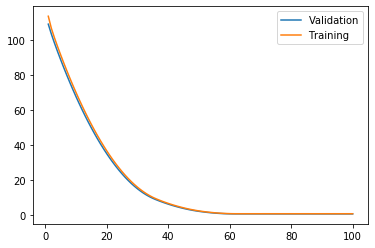

In [205]:
plt.plot(range(1,len(acc)+1), val_loss, label='Validation')
plt.plot(range(1,len(acc)+1), loss, label='Training')
plt.legend()
plt.show()

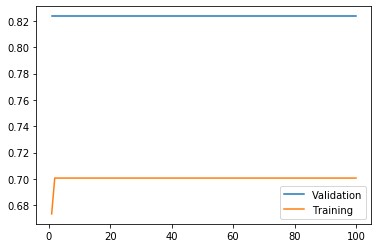

In [206]:
plt.plot(range(1,len(acc)+1), val_acc, label='Validation')
plt.plot(range(1,len(acc)+1), acc, label='Training')
plt.legend()
plt.show()

### GloVe

In [207]:
with open('/Users/skylark/Desktop/Misc/pretrained embeddings/glove.6B/glove.6B.300d.txt') as f:
    glove = f.readlines()

In [214]:
glove_weights = {}
for weight in glove:
    glove_weights[weight.split()[0]] = np.array(weight.split()[1:])

In [224]:
model = models.Sequential()

In [225]:
model.add(layers.Embedding(10000, 300, input_length=100))
model.add(layers.Bidirectional(layers.SimpleRNN(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.SimpleRNN(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.SimpleRNN(128)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 64)           21312     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 128)          16512     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                

In [219]:
embedding_glove = np.zeros((10000, 300))
for word, i in word_idx.items():
    if i<10000:
        try:
            vec = glove_weights[word]
            embedding_glove[i] = vec
        except Exception as e:    
            pass

In [226]:
model.layers[0].set_weights([embedding_glove])
model.layers[0].trainable = False

In [227]:
model.compile(optimizer=optimizers.RMSprop(2e4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, batch_size=16, epochs=1000, validation_split=0.1)

Train on 147 samples, validate on 17 samples
Epoch 1/1000
147/147 [==============================] - 4s 27ms/step - loss: 435064875029692864.0000 - acc: 0.5918 - val_loss: 29095517212377088.0000 - val_acc: 0.5294
Epoch 2/1000
147/147 [==============================] - 2s 12ms/step - loss: 24567590817198388.0000 - acc: 0.6599 - val_loss: 24164819120931780.0000 - val_acc: 0.3529
Epoch 3/1000
147/147 [==============================] - 2s 12ms/step - loss: 14417488566700324.0000 - acc: 0.6667 - val_loss: 28562129139886444.0000 - val_acc: 0.4118
Epoch 4/1000
147/147 [==============================] - 2s 12ms/step - loss: 5068937977044156.0000 - acc: 0.7415 - val_loss: 12537614874767600.0000 - val_acc: 0.5294
Epoch 5/1000
147/147 [==============================] - 2s 15ms/step - loss: 7046330526009525.0000 - acc: 0.7891 - val_loss: 15591194130367430.0000 - val_acc: 0.7059
Epoch 6/1000
147/147 [==============================] - 2s 14ms/step - loss: 2709553443561193.5000 - acc: 0.8299 - val_lo